In [1]:
%matplotlib widget

import sys
import os
import time
import math as math
from datetime import datetime
import pickle 
import numpy as np
import astropy as ast
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.table import Table, hstack, vstack, Column
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import Angle
from astropy.time import Time
from photutils.aperture import EllipticalAnnulus, aperture_photometry
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import scipy.integrate
import scipy.constants
import scipy.special
import scipy.misc
from scipy import integrate
from scipy.optimize import curve_fit
import scipy.interpolate
from scipy.interpolate import CubicSpline
import glob2
import shutil
from IPython.display import clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import axes3d
from tqdm.notebook import tqdm as tqdm

import cv2

import Utility3_4 as ut

from readMDA_Mod2 import *
from ScanFunctions_plot_mod import *
import mda as mda

import pprint

b = 10**5

DimY = 1096
DimX = 1936

Offset = 2 #ADU Blacklevel Offset

Gain = 2.398
SigmaGain = 0.069

IEX_nData not imported


In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
#Loading in Calibrated Uncoated Photodiode (UPD) Responsivity Curve

UPD_Calibration = Table.read("CalibratedPhotodiodeResponsivity.csv", format='ascii.csv')
UPD_Calibration = [np.array(UPD_Calibration['Responsivity']), np.array(UPD_Calibration['Energy'])]

UPD_Responsivity = UPD_Calibration[0]
UPD_Energy = UPD_Calibration[1]

SiO2_Attenuation = Table.read("SiO2AttenLength.csv", format='ascii.csv') #Credit to CXRO
SiO2_Attenuation = [np.array(SiO2_Attenuation['AttenLength_um']), np.array(SiO2_Attenuation['Energy_eV'])]

SiO2_AttenLength = SiO2_Attenuation[0]
SiO2_Energy = SiO2_Attenuation[1]

In [4]:
#SiO2 over a wider range of photon energies
SiO2_AttenuationLonger = Table.read("SiO2AttenLengthLonger.csv", format='ascii.csv') #Credit to CXRO
SiO2_AttenuationLonger = [np.array(SiO2_AttenuationLonger['AttenLength_um']), np.array(SiO2_AttenuationLonger['Energy_eV'])]

SiO2_AttenLengthLonger = SiO2_AttenuationLonger[0]
SiO2_EnergyLonger = SiO2_AttenuationLonger[1]

In [5]:
#SiO2 over an even wider range of photon energies
SiO2_AttenuationEvenLonger = Table.read("SiO2AttenLengthEvenLonger.csv", format='ascii.csv') #Credit to CXRO
SiO2_AttenuationEvenLonger = [np.array(SiO2_AttenuationEvenLonger['AttenLength_um']), np.array(SiO2_AttenuationEvenLonger['Energy_eV'])]

SiO2_AttenLengthEvenLonger = SiO2_AttenuationEvenLonger[0]
SiO2_EnergyEvenLonger = SiO2_AttenuationEvenLonger[1]

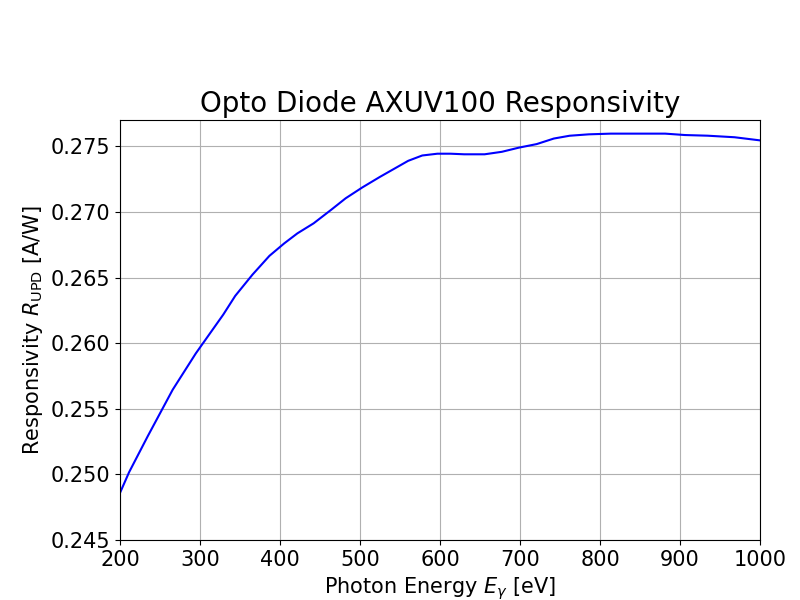

In [6]:
#Plotting UPD Responsivity Curve
f, ax = plt.subplots(1, 1)
ax.plot(UPD_Energy,UPD_Responsivity, color = 'blue')
ax.set_xlabel('Photon Energy $E_{\gamma}$ [eV]')
ax.set_ylabel('Responsivity $R_{\mathrm{UPD}}$ [A/W]')
#ax.set_title("Calibrated Uncoated Photodiode (UPD) Responsivity Curve", loc = 'center')
ax.set_title("Opto Diode AXUV100 Responsivity", loc = 'center')
#ax.set_title(r"Responsivity Curve"
#               "\n" r"Calibrated Uncoated Photodiode (UPD)", loc = 'center')
#ax.set_xlim([xaxis18_on[0], np.size(xaxis18_on)])
ax.set_xlim([200, 1000])
ax.set_ylim([0.245, 0.277])
#plt.subplots_adjust(hspace = 0.35)
#ax.legend()
#figure = plt.gcf()
#figure.set_size_inches(9, 6)
f.set_size_inches(8, 6)
#plt.subplots_adjust(left=0.1,
#                    bottom=0.1,
#                    right=0.95,
#                    top=0.95,
#                    wspace=0.4,
#                    hspace=0.2)

plt.subplots_adjust(left=0.15,
                    bottom=0.1,
                    right=0.95,
                    top=0.80,
                    wspace=0.4,
                    hspace=0.2)
plt.grid(True)
plt.show()
plt.savefig("AXUV100_R_Curve2.png", dpi=200,bbox_inches='tight')
#OptoDiode AXUV100

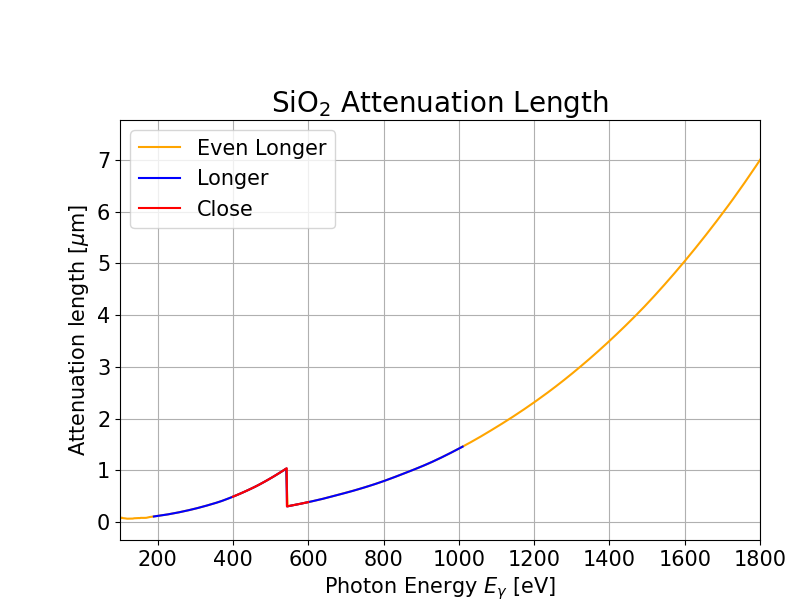

In [7]:
#Plotting SiO2 Attenuation Length
f, ax = plt.subplots(1, 1)
ax.plot(SiO2_EnergyEvenLonger,SiO2_AttenLengthEvenLonger, color = 'orange', label = 'Even Longer')
ax.plot(SiO2_EnergyLonger,SiO2_AttenLengthLonger, color = 'blue', label = 'Longer')
ax.plot(SiO2_Energy,SiO2_AttenLength, color = 'red', label = 'Close')
ax.set_xlabel('Photon Energy $E_{\gamma}$ [eV]')
ax.set_ylabel('Attenuation length [$\mu$m]')
ax.set_title("SiO$_2$ Attenuation Length", loc = 'center')
#ax.set_xlim([200, 1000])
ax.set_xlim([100, 1800])
ax.legend()
f.set_size_inches(8, 6)
plt.subplots_adjust(left=0.15,
                    bottom=0.1,
                    right=0.95,
                    top=0.80,
                    wspace=0.4,
                    hspace=0.2)
plt.grid(True)
plt.show()

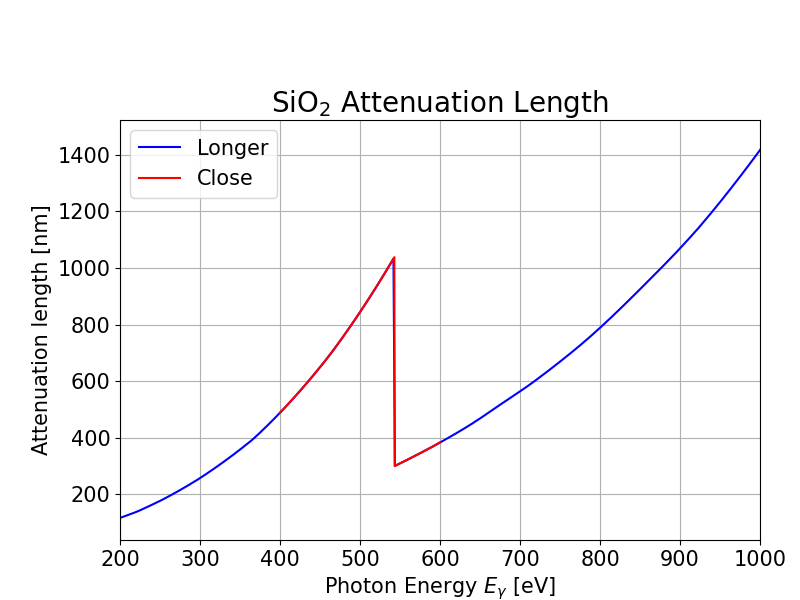

In [8]:
#unit = {'pA':1e-12, 'nA':1e-9, 'uA':1e-6, 'mA':1e-3}
SiO2_AttenLength_nm = (SiO2_AttenLength*1e-6)/1e-9
SiO2_AttenLength_nmLonger = (SiO2_AttenLengthLonger*1e-6)/1e-9

#Plotting SiO2 Attenuation Length (nm)
f, ax = plt.subplots(1, 1)
ax.plot(SiO2_EnergyLonger,SiO2_AttenLength_nmLonger, color = 'blue', label = 'Longer')
ax.plot(SiO2_Energy,SiO2_AttenLength_nm, color = 'red', label = 'Close')
ax.set_xlabel('Photon Energy $E_{\gamma}$ [eV]')
ax.set_ylabel('Attenuation length [nm]')

ax.set_title("SiO$_2$ Attenuation Length", loc = 'center')
ax.set_xlim([200, 1000])
#ax.set_ylim([275, 1075])
ax.legend()
f.set_size_inches(8, 6)
plt.subplots_adjust(left=0.15,
                    bottom=0.1,
                    right=0.95,
                    top=0.80,
                    wspace=0.4,
                    hspace=0.2)
plt.grid(True)
plt.show()

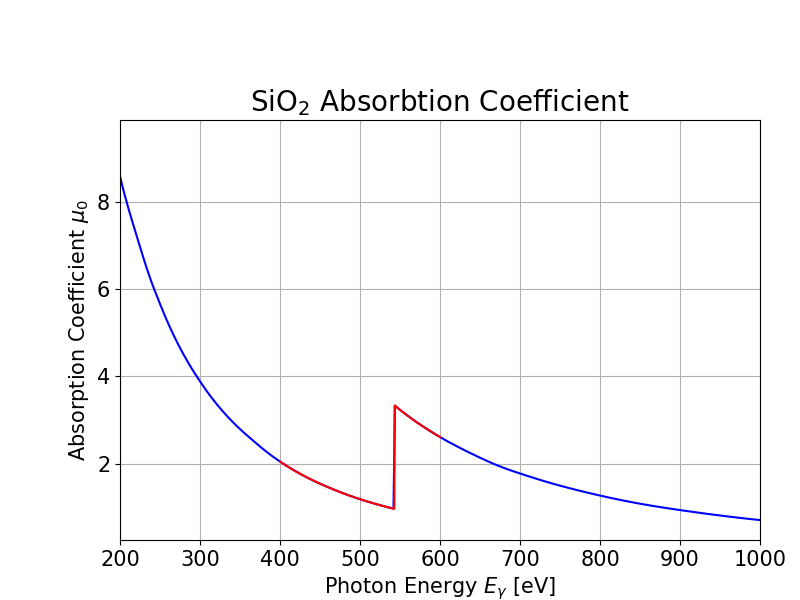

In [9]:
#Plotting SiO2 Absorption Coefficient
f, ax = plt.subplots(1, 1)
ax.plot(SiO2_EnergyLonger,1/SiO2_AttenLengthLonger, color = 'blue', label = 'Longer')
ax.plot(SiO2_Energy,1/SiO2_AttenLength, color = 'red', label = 'Close')
ax.set_xlabel('Photon Energy $E_{\gamma}$ [eV]')
ax.set_ylabel('Absorption Coefficient $\mu_{0}$')
ax.set_title("SiO$_2$ Absorbtion Coefficient", loc = 'center')
ax.set_xlim([200, 1000])
f.set_size_inches(8, 6)
plt.subplots_adjust(left=0.15,
                    bottom=0.1,
                    right=0.95,
                    top=0.80,
                    wspace=0.4,
                    hspace=0.2)
plt.grid(True)
plt.show()

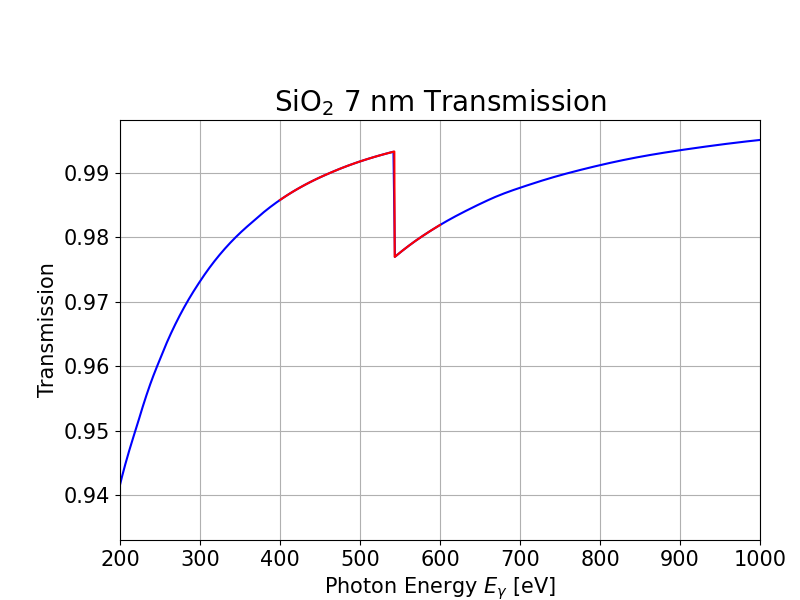

In [10]:
#SiO2 Transmission

t0 = 7 #nm
SiO2_AttenLength_nm = (SiO2_AttenLength*1e-6)/1e-9

T = np.exp((-1*t0)/SiO2_AttenLength_nm)

SiO2_AttenLength_nmLonger = (SiO2_AttenLengthLonger*1e-6)/1e-9

T_Longer = np.exp((-1*t0)/SiO2_AttenLength_nmLonger)

#Plotting UPD Responsivity Curve
f, ax = plt.subplots(1, 1)
ax.plot(SiO2_EnergyLonger,T_Longer, color = 'blue', label = 'Longer')
ax.plot(SiO2_Energy,T, color = 'red', label = 'Close')
ax.set_xlabel('Photon Energy $E_{\gamma}$ [eV]')
ax.set_ylabel('Transmission')
ax.set_title("SiO$_2$ 7 nm Transmission", loc = 'center')
ax.set_xlim([200, 1000])
f.set_size_inches(8, 6)
plt.subplots_adjust(left=0.15,
                    bottom=0.1,
                    right=0.95,
                    top=0.80,
                    wspace=0.4,
                    hspace=0.2)
plt.grid(True)
plt.show()

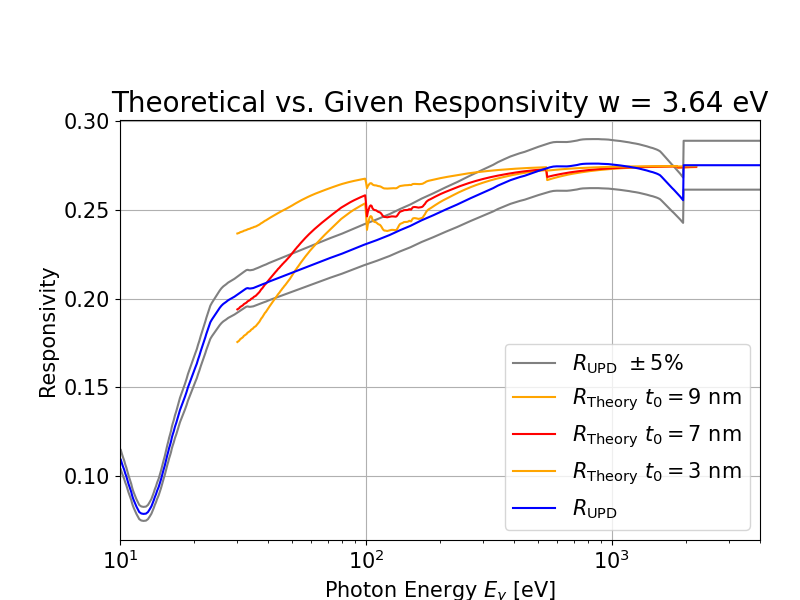

In [11]:
#Theoretical Responsivity

w = 3.64

t0_9 = 9
t0_8 = 8
t0_7 = 7 #nm
t0_6 = 6
t0_5 = 5
t0_4 = 4
t0_3 = 3
SiO2_AttenLength_nm = (SiO2_AttenLengthEvenLonger*1e-6)/1e-9

T9 = np.exp((-1*t0_9)/SiO2_AttenLength_nm)
T8 = np.exp((-1*t0_8)/SiO2_AttenLength_nm)
T7 = np.exp((-1*t0_7)/SiO2_AttenLength_nm)
T6 = np.exp((-1*t0_6)/SiO2_AttenLength_nm)
T5 = np.exp((-1*t0_5)/SiO2_AttenLength_nm)
T4 = np.exp((-1*t0_4)/SiO2_AttenLength_nm)
T3 = np.exp((-1*t0_3)/SiO2_AttenLength_nm)

R_Theory9 = T9/w
R_Theory8 = T8/w
R_Theory7 = T7/w
R_Theory6 = T6/w
R_Theory5 = T5/w
R_Theory4 = T4/w
R_Theory3 = T3/w

#Plotting UPD Responsivity Curves
f, ax = plt.subplots(1, 1)
ax.plot(UPD_Energy,1.05*UPD_Responsivity, color = 'grey', label = "$R_{\mathrm{UPD}}\ \pm 5$%")
ax.plot(UPD_Energy,0.95*UPD_Responsivity, color = 'grey')
ax.plot(SiO2_EnergyEvenLonger, R_Theory9, color = 'orange', label = "$R_{\mathrm{Theory}}$ $t_0 = 9$ nm" )
#ax.plot(SiO2_EnergyLonger, R_Theory8, color = 'grey', label = "$R_{\mathrm{Theory}}$ $t_0 = 8$ nm" )
ax.plot(SiO2_EnergyEvenLonger, R_Theory7, color = 'red', label = "$R_{\mathrm{Theory}}$ $t_0 = 7$ nm" )
#ax.plot(SiO2_EnergyLonger, R_Theory5, color = 'yellow', label = "$R_{\mathrm{Theory}}$ $t_0 = 5$ nm" )
ax.plot(SiO2_EnergyEvenLonger, R_Theory3, color = 'orange', label = "$R_{\mathrm{Theory}}$ $t_0 = 3$ nm" )
ax.plot(UPD_Energy,UPD_Responsivity, color = 'blue', label = "$R_{\mathrm{UPD}}$")

ax.set_xlabel('Photon Energy $E_{\gamma}$ [eV]')
ax.set_ylabel('Responsivity')
ax.set_title("Theoretical vs. Given Responsivity w = 3.64 eV", loc = 'center')
ax.set_xlim([10, 4000])
ax.legend()
ax.set_xscale("log")
f.set_size_inches(8, 6)

plt.subplots_adjust(left=0.15,
                    bottom=0.1,
                    right=0.95,
                    top=0.80,
                    wspace=0.4,
                    hspace=0.2)
plt.grid(True)
plt.show()

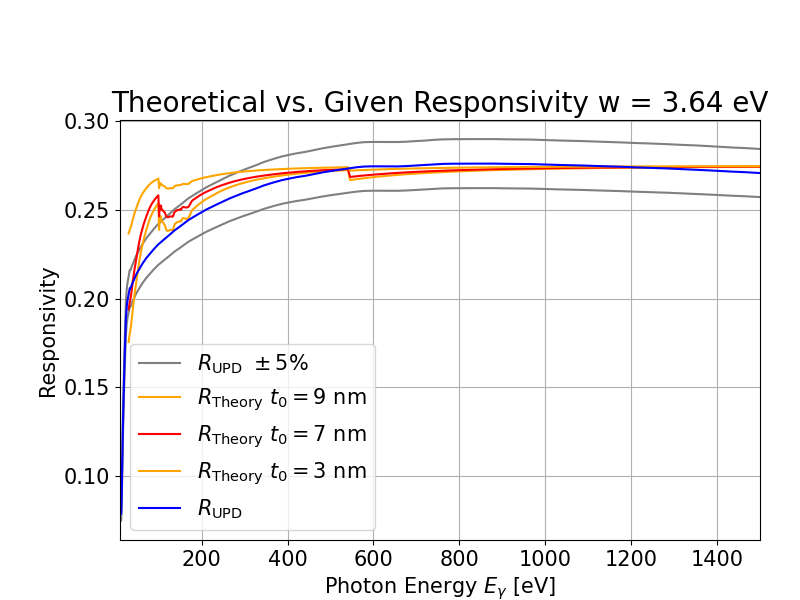

In [12]:
#Theoretical Responsivity
w = 3.64

t0_9 = 9
t0_8 = 8
t0_7 = 7 #nm
t0_6 = 6
t0_5 = 5
t0_4 = 4
t0_3 = 3
SiO2_AttenLength_nm = (SiO2_AttenLengthEvenLonger*1e-6)/1e-9

T9 = np.exp((-1*t0_9)/SiO2_AttenLength_nm)
T8 = np.exp((-1*t0_8)/SiO2_AttenLength_nm)
T7 = np.exp((-1*t0_7)/SiO2_AttenLength_nm)
T6 = np.exp((-1*t0_6)/SiO2_AttenLength_nm)
T5 = np.exp((-1*t0_5)/SiO2_AttenLength_nm)
T4 = np.exp((-1*t0_4)/SiO2_AttenLength_nm)
T3 = np.exp((-1*t0_3)/SiO2_AttenLength_nm)

R_Theory9 = T9/w
R_Theory8 = T8/w
R_Theory7 = T7/w
R_Theory6 = T6/w
R_Theory5 = T5/w
R_Theory4 = T4/w
R_Theory3 = T3/w

#Plotting UPD Responsivity Curves
f, ax = plt.subplots(1, 1)
ax.plot(UPD_Energy,1.05*UPD_Responsivity, color = 'grey', label = "$R_{\mathrm{UPD}}\ \pm 5$%")
ax.plot(UPD_Energy,0.95*UPD_Responsivity, color = 'grey')
ax.plot(SiO2_EnergyEvenLonger, R_Theory9, color = 'orange', label = "$R_{\mathrm{Theory}}$ $t_0 = 9$ nm" )
#ax.plot(SiO2_EnergyLonger, R_Theory8, color = 'grey', label = "$R_{\mathrm{Theory}}$ $t_0 = 8$ nm" )
ax.plot(SiO2_EnergyEvenLonger, R_Theory7, color = 'red', label = "$R_{\mathrm{Theory}}$ $t_0 = 7$ nm" )
#ax.plot(SiO2_EnergyLonger, R_Theory5, color = 'yellow', label = "$R_{\mathrm{Theory}}$ $t_0 = 5$ nm" )
ax.plot(SiO2_EnergyEvenLonger, R_Theory3, color = 'orange', label = "$R_{\mathrm{Theory}}$ $t_0 = 3$ nm" )
ax.plot(UPD_Energy,UPD_Responsivity, color = 'blue', label = "$R_{\mathrm{UPD}}$")

ax.set_xlabel('Photon Energy $E_{\gamma}$ [eV]')
ax.set_ylabel('Responsivity')
ax.set_title("Theoretical vs. Given Responsivity w = 3.64 eV", loc = 'center')
ax.set_xlim([10, 1500])
ax.legend()

f.set_size_inches(8, 6)
plt.subplots_adjust(left=0.15,
                    bottom=0.1,
                    right=0.95,
                    top=0.80,
                    wspace=0.4,
                    hspace=0.2)
plt.grid(True)
plt.show()

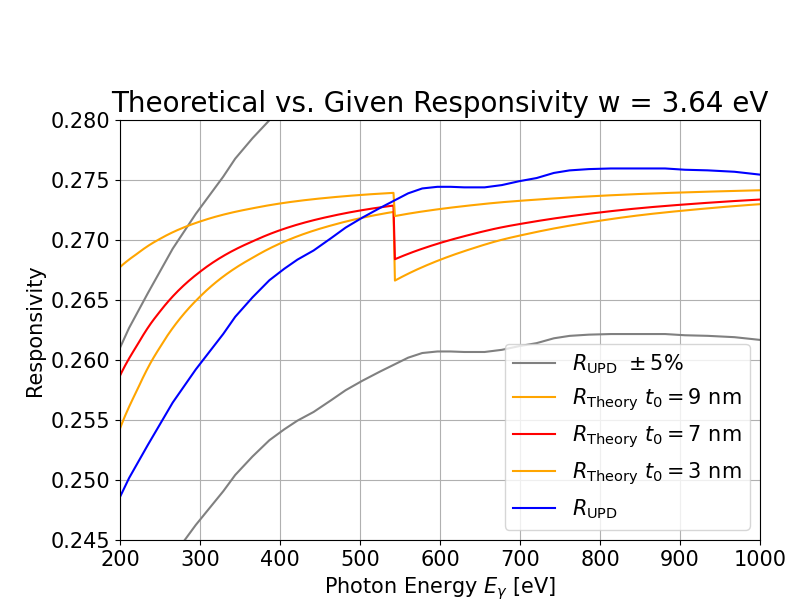

In [13]:
#Theoretical Responsivity

w = 3.64

t0_9 = 9
t0_8 = 8
t0_7 = 7 #nm
t0_6 = 6
t0_5 = 5
t0_4 = 4
t0_3 = 3
SiO2_AttenLength_nm = (SiO2_AttenLengthLonger*1e-6)/1e-9

T9 = np.exp((-1*t0_9)/SiO2_AttenLength_nm)
T8 = np.exp((-1*t0_8)/SiO2_AttenLength_nm)
T7 = np.exp((-1*t0_7)/SiO2_AttenLength_nm)
T6 = np.exp((-1*t0_6)/SiO2_AttenLength_nm)
T5 = np.exp((-1*t0_5)/SiO2_AttenLength_nm)
T4 = np.exp((-1*t0_4)/SiO2_AttenLength_nm)
T3 = np.exp((-1*t0_3)/SiO2_AttenLength_nm)

R_Theory9 = T9/w
R_Theory8 = T8/w
R_Theory7 = T7/w
R_Theory6 = T6/w
R_Theory5 = T5/w
R_Theory4 = T4/w
R_Theory3 = T3/w

#Plotting UPD Responsivity Curves
f, ax = plt.subplots(1, 1)
ax.plot(UPD_Energy,1.05*UPD_Responsivity, color = 'grey', label = "$R_{\mathrm{UPD}}\ \pm 5$%")
ax.plot(UPD_Energy,0.95*UPD_Responsivity, color = 'grey')
ax.plot(SiO2_EnergyLonger, R_Theory9, color = 'orange', label = "$R_{\mathrm{Theory}}$ $t_0 = 9$ nm" )
#ax.plot(SiO2_EnergyLonger, R_Theory8, color = 'grey', label = "$R_{\mathrm{Theory}}$ $t_0 = 8$ nm" )
ax.plot(SiO2_EnergyLonger, R_Theory7, color = 'red', label = "$R_{\mathrm{Theory}}$ $t_0 = 7$ nm" )
#ax.plot(SiO2_EnergyLonger, R_Theory5, color = 'yellow', label = "$R_{\mathrm{Theory}}$ $t_0 = 5$ nm" )
ax.plot(SiO2_EnergyLonger, R_Theory3, color = 'orange', label = "$R_{\mathrm{Theory}}$ $t_0 = 3$ nm" )
ax.plot(UPD_Energy,UPD_Responsivity, color = 'blue', label = "$R_{\mathrm{UPD}}$")

ax.set_xlabel('Photon Energy $E_{\gamma}$ [eV]')
ax.set_ylabel('Responsivity')
ax.set_title("Theoretical vs. Given Responsivity w = 3.64 eV", loc = 'center')
ax.set_xlim([200, 1000])
ax.set_ylim([0.245, 0.277])
ax.set_ylim([0.245, 0.280])
ax.legend()
f.set_size_inches(8, 6)


plt.subplots_adjust(left=0.15,
                    bottom=0.1,
                    right=0.95,
                    top=0.80,
                    wspace=0.4,
                    hspace=0.2)
plt.grid(True)
plt.show()

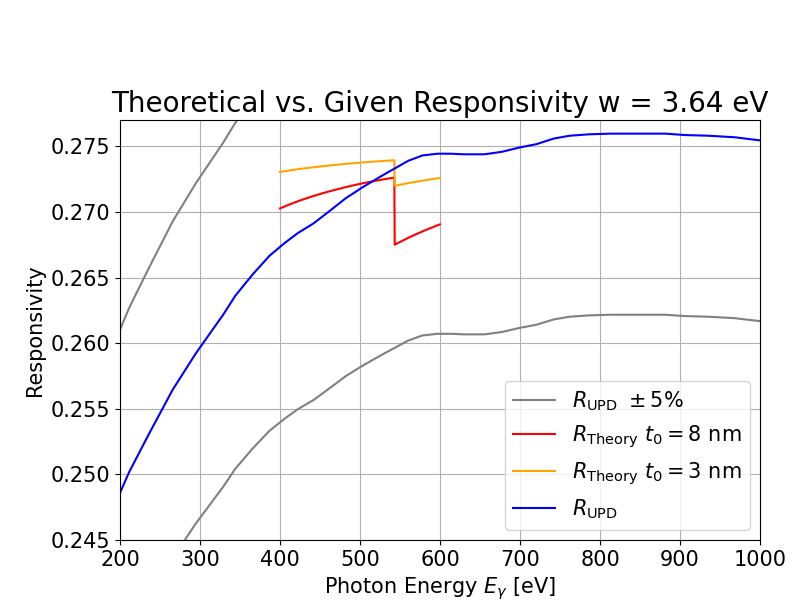

In [14]:
#Theoretical Responsivity

w = 3.64

t0_9 = 9
t0_8 = 8
t0_7 = 7 #nm
t0_6 = 6
t0_5 = 5
t0_4 = 4
t0_3 = 3
SiO2_AttenLength_nm = (SiO2_AttenLength*1e-6)/1e-9

T9 = np.exp((-1*t0_9)/SiO2_AttenLength_nm)
T8 = np.exp((-1*t0_8)/SiO2_AttenLength_nm)
T7 = np.exp((-1*t0_7)/SiO2_AttenLength_nm)
T6 = np.exp((-1*t0_6)/SiO2_AttenLength_nm)
T5 = np.exp((-1*t0_5)/SiO2_AttenLength_nm)
T4 = np.exp((-1*t0_4)/SiO2_AttenLength_nm)
T3 = np.exp((-1*t0_3)/SiO2_AttenLength_nm)

R_Theory9 = T9/w
R_Theory8 = T8/w
R_Theory7 = T7/w
R_Theory6 = T6/w
R_Theory5 = T5/w
R_Theory4 = T4/w
R_Theory3 = T3/w

#Plotting UPD Responsivity Curves
f, ax = plt.subplots(1, 1)
ax.plot(UPD_Energy,1.05*UPD_Responsivity, color = 'grey', label = "$R_{\mathrm{UPD}}\ \pm 5$%")
ax.plot(UPD_Energy,0.95*UPD_Responsivity, color = 'grey')
#ax.plot(SiO2_EnergyEvenLonger, R_Theory9, color = 'orange', label = "$R_{\mathrm{Theory}}$ $t_0 = 9$ nm" )
ax.plot(SiO2_Energy, R_Theory8, color = 'red', label = "$R_{\mathrm{Theory}}$ $t_0 = 8$ nm" )
#ax.plot(SiO2_EnergyEvenLonger, R_Theory7, color = 'red', label = "$R_{\mathrm{Theory}}$ $t_0 = 7$ nm" )
#ax.plot(SiO2_EnergyLonger, R_Theory5, color = 'yellow', label = "$R_{\mathrm{Theory}}$ $t_0 = 5$ nm" )
ax.plot(SiO2_Energy, R_Theory3, color = 'orange', label = "$R_{\mathrm{Theory}}$ $t_0 = 3$ nm" )
ax.plot(UPD_Energy,UPD_Responsivity, color = 'blue', label = "$R_{\mathrm{UPD}}$")

ax.set_xlabel('Photon Energy $E_{\gamma}$ [eV]')
ax.set_ylabel('Responsivity')
ax.set_title("Theoretical vs. Given Responsivity w = 3.64 eV", loc = 'center')
ax.set_xlim([200, 1000])
ax.set_ylim([0.245, 0.277])
ax.legend()
f.set_size_inches(8, 6)
plt.subplots_adjust(left=0.15,
                    bottom=0.1,
                    right=0.95,
                    top=0.80,
                    wspace=0.4,
                    hspace=0.2)
plt.grid(True)
plt.show()

***
***

In [15]:
#The average of 8 nm and 3 nm is 5.5 nm, so from theory we get 

w = 3.64

SiO2_AttenLength_nm = (SiO2_AttenLength*1e-6)/1e-9

T8 = np.exp((-1*8)/SiO2_AttenLength_nm)
T5_5 = np.exp((-1*5.5)/SiO2_AttenLength_nm)
T3 = np.exp((-1*3)/SiO2_AttenLength_nm)

R_Theory8 = T8/w
R_Theory5_5 = T5_5/w
R_Theory3 = T3/w

#From NIST Theory:
#Using Cubic Splines Fits

CubicSplineFit8 = CubicSpline(SiO2_Energy,R_Theory8)
R_Theory8_490p5 = float(CubicSplineFit8(490.5))

CubicSplineFit5_5 = CubicSpline(SiO2_Energy,R_Theory5_5)
R_Theory5_5_490p5 = float(CubicSplineFit5_5(490.5))

CubicSplineFit3 = CubicSpline(SiO2_Energy,R_Theory3)
R_Theory3_490p5 = float(CubicSplineFit3(490.5))

PlusValue = R_Theory3_490p5 - R_Theory5_5_490p5
MinusValue = R_Theory5_5_490p5 - R_Theory8_490p5

#From John's Data
#Using Cubic Splines Fits

CubicSplineFitUPD = CubicSpline(UPD_Energy,UPD_Responsivity)
R_UPD_490p5 = float(CubicSplineFitUPD(490.5))

#round(R_UPD_490p5,4)

print("From NIST Theory:")
print("R = " + str(round(R_Theory5_5_490p5,4)) + " + " + str(round(PlusValue,4)) + " - " + str(round(MinusValue,4)))
print("")
print("From Johns Data: ")
print("R = " + str(round(R_UPD_490p5,4)))

From NIST Theory:
R = 0.2729 + 0.0008 - 0.0008

From Johns Data: 
R = 0.2714


In [16]:
print(round(R_Theory5_5_490p5/R_UPD_490p5,4))
print(round(PlusValue/R_Theory5_5_490p5,4))

1.0054
0.0031


The theory and the data from John are within 0.54% of each other, however the uncertainty on the theory is only 0.31%. What if I just take the maximum difference from John to theory as the uncertainty?

In [18]:
NewPlusValue = R_Theory3_490p5 - R_UPD_490p5
PercentUncertainty = (NewPlusValue/R_UPD_490p5)*100
print("Responsivity with New Uncertainty: ")
print("R = " + str(round(R_UPD_490p5,3)) + " +/- " + str(round(NewPlusValue,3)) + " or " + str(round(PercentUncertainty,2)) + "%")
print("")
print("R = " + str(R_UPD_490p5))
print("dR = " + str(NewPlusValue))

Responsivity with New Uncertainty: 
R = 0.271 +/- 0.002 or 0.85%

R = 0.27138859346578026
dR = 0.002313939712164259
